In [151]:
### SPEI calc and plot
# Calculates the standardized precipitation and evapotranspiration (SPEI) drought index for 1 CMIP6 model and plots a timeseries 
# Output: plot of average SPEI over Ghana
# Steps:
#      1. Imports climate model data
#      2. Subsets model to Ghana
#      3. Calcualtes monthly average temp and precip
#      4. Calculates potential evapotranspiation and SPEI using climate indices packages, saving as a cube
#      5. Gets average SPEI over country
#      6. Turns cube into dataframe (may be useful if plotting multiple models)
#      7. Plots SPEI timeseries
#
## Author: S Chapman
## Date: 20/05/2021

#Import packages
import iris
import iris.plot as iplt
import iris.coord_categorisation

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import copy

import climate_indices
from climate_indices import compute, indices

In [119]:
## Load data
file_path = '/gws/pw/j05/cop26_hackathons/leeds/ministry/Tom_W/CMIP6_1980-2010_L1/ACCESS-CM2/'

#load precip
pr = iris.load_cube(file_path + 'ACCESS-CM2.pr.WA.30.nc')

#load tas
tas = iris.load_cube(file_path + 'ACCESS-CM2.tas.WA.30.nc')

#convert units
pr.convert_units('kg m-2 day-1')
tas.convert_units('celsius')

In [127]:
#extract to region of interest
def ghana_lat(input):
    return -2.1 <= input <= -0.3

def ghana_lon(input):
    return 6.0 <= input <= 8.1

ghana_con = iris.Constraint(latitude = ghana_lat, longitude =  ghana_lon)

ghana_pr = pr.extract(ghana_con)
ghana_tas = tas.extract(ghana_con)


air_temperature / (celsius)         (time: 10957; latitude: 3; longitude: 3)
     Dimension coordinates:
          time                           x                -             -
          latitude                       -                x             -
          longitude                      -                -             x
     Scalar coordinates:
          height: 2.0 m
     Attributes:
          CDI: Climate Data Interface version 1.9.8 (https://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.8 (https://mpimet.mpg.de/cdo)
          Conventions: CF-1.7 CMIP-6.2
          activity_id: CMIP
          branch_method: standard
          branch_time_in_child: 0.0
          branch_time_in_parent: 0.0
          cmor_version: 3.4.0
          comment: near-surface (usually, 2 meter) air temperature
          creation_date: 2019-11-09T02:13:27Z
          data_specs_version: 01.00.30
          experiment: all-forcing simulation of the recent past
          experiment_id: hi

In [128]:
#add month coord and calculate monthly mean
iris.coord_categorisation.add_month_number(ghana_pr, 'time', name='month')
iris.coord_categorisation.add_month_number(ghana_tas, 'time', name='month')
iris.coord_categorisation.add_year(ghana_pr, 'time', name='year')
iris.coord_categorisation.add_year(ghana_tas, 'time', name='year')

pr_mean = ghana_pr.aggregated_by(['month', 'year'], iris.analysis.MEAN)
tas_mean = ghana_tas.aggregated_by(['month', 'year'], iris.analysis.MEAN)

In [142]:
#set up variables

syear = 1981
calib_year_init = 1981
calib_year_final = 1991
dims = pr_mean.shape

#create cubes for storing data
spei_cube = copy.deepcopy(pr_mean)
pet_cube = copy.deepcopy(tas_mean)

In [143]:
for j in np.arange(dims[1]):
    for k in np.arange(dims[2]):

        x_pr = pr_mean[:, j, k].data
        x_tas = tas_mean[:, j, k].data

        lat = pr_mean[0, j,k].coord('latitude').points[0]
        
        #calculate pet
        pet = indices.pet(x_tas, lat, syear)
        pet_cube.data[:,j,k] = pet
        
        #calcualte spei
        kwargs = dict(
            precips_mm = x_pr,
            pet_mm = pet[0:dims[0]],
            scale = 1, # months over which to calculate SPEI, i.e., 3 month running mean etc
            distribution = indices.Distribution.gamma,
            periodicity = indices.compute.Periodicity.monthly, #time scale of input data (needs to be monthly for SPEI)
            data_start_year = syear,
            calibration_year_initial = calib_year_init,
            calibration_year_final = calib_year_final,
            fitting_params=None
        )
        spei = indices.spei(**kwargs)
        
        spei_cube.data[:,j,k] = spei
        
        

In [149]:
##plot time series
#calculate mean SPEI over ghana
spei_mean = spei_cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)

In [172]:
#turn into dataframe and extract year

def cube_to_frame(cube_list): # set up in case calculate SPEI for multiple models
    df = pd.DataFrame(columns = ['mod', 'sim', 'year', 'month', 'value'])
    
    for i in np.arange(len(cube_list)):
        cube =  cube_list[i]
        mod = 'ACCESS' #extract from attribtues later
        sim = 'hist' #extract from attributes later
        
        x = cube.data
        x = x[~x.mask].flatten() #if masked to land sea, which isn't as moment
        
        
        year =  cube.coord('year').points
        month = cube.coord('month').points
        
        y = pd.DataFrame(columns =   ['mod', 'sim', 'year', 'month', 'value'])
       
        y['value'] = x
        y['year'] = year
        y['mod'] = mod
        y['sim'] = sim
        y['month'] = month
        
        df= df.append(y)
    
    return df

spei_df = cube_to_frame([spei_mean])

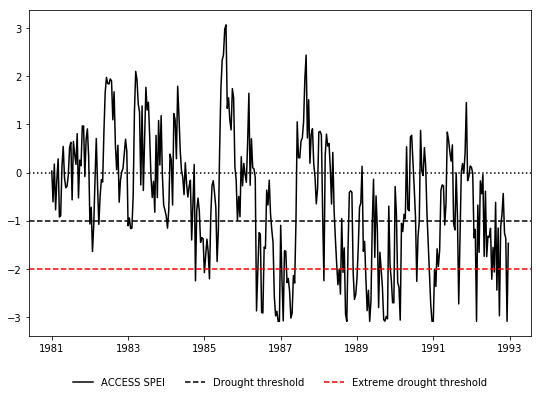

In [201]:
fig = plt.figure(figsize = (9,6))
ax =  fig.add_subplot(111)

years =  np.unique(spei_df['year'])

ax.set_xticks(np.arange(0, 420, 60))
ax.set_xticklabels(years[::2])


ax.plot(spei_df['value'], c = 'black', label = 'ACCESS SPEI')

ax.axhline(y = 0, color = 'black', linestyle = 'dotted')
ax.axhline(y = -1, color = 'black', linestyle = 'dashed', label = 'Drought threshold')
ax.axhline(y = -2, color = 'red', linestyle = 'dashed', label = 'Extreme drought threshold')

ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.10), ncol = 3, frameon = False)
